<a href="https://colab.research.google.com/github/YuvanBharathi13/DeepLearning/blob/main/Food_Vission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOOD VISION

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

`from the diagram below as you can see we will be using the NVIDIA Tesla T4 GPU with a compute capability of 7.5.`

In [2]:
!nvidia-smi

Tue Jul 22 05:47:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             16W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Mixed Precision

- In this project we will be using Mixed precision.
- Mixed precision is the use of both 16-bit and 32-bit floating-point types in a model during training to make it run faster and use less memory.
- Mixed precsion can run on any hardware but it will only speed up models on recent NVIDIA GPUs which have a compute power greater or equal to 7.0.
- lucky for us, colab gives access to NVIDIA T4 GPU which has a compute power of 7.5. yayyy!!!

## Helper functions

- These are some of the functions we would be using throughout the project

In [3]:
def plot_curves(history):
  loss_train = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)

  plt.plot(epochs,loss_train,'r',label='Training Loss')
  plt.plot(epochs,val_loss,'b',label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)

  plt.plot(epochs,accuracy,'r',label='Training Accuracy')
  plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [4]:
def compare_historys(original_history, new_history, initial_epochs=5):
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Downloading Dataset

- For this project we will be working on the food101 dataset from tensorflow datasets.
- it is a dataset that contains data for 101 food classes with each class having 750 training images and 250 testing images.

In [5]:
import tensorflow_datasets as tfds

In [ ]:
(train_data,test_data), ds_info = tfds.load(name='food101',
                                            split=['train','validation'],
                                            shuffle_files=True, # shuffles the images as it downloads
                                            as_supervised=True, # the dataset will come with the labels (data,label)
                                            with_info=True) # we are downloading the meta data as well

## Exploring the Dataset

- Questions that need to be asked -
  1. The shape of our input data (image tensors)
  2. The datatype of our input data
  3. What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
  4. Do the labels match up with the class names?

### Image shapes

- from the meta data we can see the shape but it has the values None.
- this happens when all the images in the dataset dont have the same shape.

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

### Image Data type

- from the output of the cell below we can see that the data type of the image is uint8, which is unsigned 8 bit integers.
- this means the pixel values of an image range from `0-255`.
- For the label we can see it is intger 64.

In [8]:
sample_image_tuple = train_data.take(1)
sample_image_tuple # will return a random image each time you run it

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### Class labels

In [9]:
class_names = ds_info.features['label'].names
class_names[10:20] # 10 of the food classes

['bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [10]:
print('pizza' in class_names) # yay pizza is there

True


### label, label type, image and image shape

- we can see that the labels are not one hot encoded

(512, 512, 3)
<dtype: 'uint8'>
tf.Tensor(41, shape=(), dtype=int64)
french_onion_soup


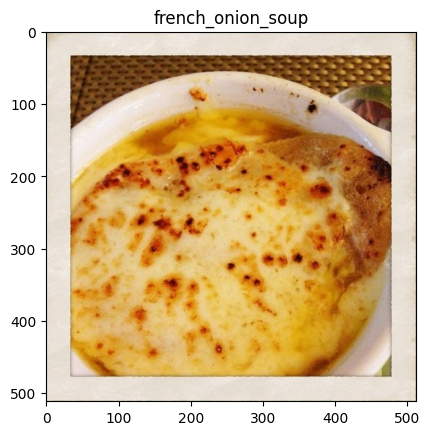

In [12]:
for image, label in sample_image_tuple:
  print(image.shape)
  print(image.dtype)
  print(label)
  print(class_names[label.numpy()]) # since it is tensor we convert it to a numpy variable
  plt.imshow(image)
  plt.title(class_names[label.numpy()])
  plt.show()

### Image pixel values

In [ ]:
image # all values between 0-255

<tf.Tensor: shape=(512, 289, 3), dtype=uint8, numpy=
array([[[145, 151, 125],
        [157, 163, 137],
        [159, 165, 139],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [197, 207, 198]],

       [[146, 152, 126],
        [156, 162, 136],
        [158, 164, 138],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 200]],

       [[150, 156, 130],
        [155, 161, 135],
        [157, 163, 137],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 198]],

       ...,

       [[173, 186, 177],
        [174, 187, 178],
        [176, 189, 180],
        ...,
        [181, 197, 187],
        [181, 197, 187],
        [178, 195, 187]],

       [[176, 187, 179],
        [176, 187, 179],
        [176, 189, 180],
        ...,
        [182, 198, 188],
        [182, 198, 188],
        [180, 197, 189]],

       [[178, 189, 181],
        [177, 188, 180],
        [175, 188, 179],
        ...,
        [179, 195, 18

## Data pre-processing

- Things we need to change in our dataset
  1. Our data is not scaled so we need to scale it
  2. The datatype has to be in float as models perform better on it and our current dtype is uint8.
  3. The train and test data are not in batches, so they need to be wrapped in batches
  4. and all the images have different shapes so we need to make then into (224,224,3)

In [13]:
def pre_process_img(image,label,img_shape=224):
  """Creating a function that will change the image shape to (224,224,3) and make the data
  type float32. """
  image = tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32),label

Shape of the image before was (512, 512, 3)
Datatype of the image before was <dtype: 'uint8'>
Shape of the image is (224, 224, 3)
Datatype of the image is <dtype: 'float32'>


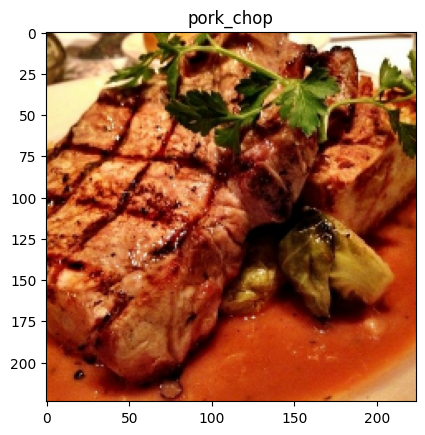

In [14]:
for image, label in sample_image_tuple:
  print(f"Shape of the image before was {image.shape}")
  print(f"Datatype of the image before was {image.dtype}")
  image, label = pre_process_img(image,label)
  print(f"Shape of the image is {image.shape}")
  print(f'Datatype of the image is {image.dtype}')
  plt.imshow(image/255)
  plt.title(class_names[label.numpy()])

## Batch and prepare dataset

1. `map()` - Applies the pre_process_img function to each image-label pair and the **num_parallel_calls  = tf.data.AUTOTUNE** tells colab to use as many CPU cores as possible which in return speeds up the process.
2. `shuffle(buffer_size=1000)` - shuffles the dataset 1000 images at a time.
3. `batch(32)` - creates batches of 32
4. `prefetch` - tells the processor to start data prcoessing of the next batch while the current batch is being processed by the model. **buffer_size = tf.data.AUTOTUNE** tells colab to choose the number of batches to prefetch while the current batch is being trained based on buffer size.

**note** - when we run the cell below the the data is not preprocessed immediatley. we are just creating a data pipeline

##### what happens -
1. When the model begins training (e.g., using .fit()), the data pipeline kicks off and starts processing images.
2. Each image is first loaded and immediately passed through a preprocessing function (map_func) which resizes, normalizes, or augments the image as needed.
3. After preprocessing, the image is placed into a shuffle buffer — a temporary storage (with a buffer size of 1000) that holds incoming images.
4. Once this buffer has enough elements, it begins randomly selecting images for output while continuing to add new ones, effectively creating a rolling, in-place shuffle.
5. These shuffled images are then grouped into batches — for example, every 32 shuffled images form one batch. As the model trains on the current batch (say, batch N), TensorFlow’s prefetch feature works in the background to prepare the next batch (batch N+1), helping to minimize data loading delays and keep training efficient.

In [15]:
# Train data
train_data = train_data.map(map_func=pre_process_img,num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Test data
test_data = test_data.map(map_func=pre_process_img,num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating callbacks

In [17]:
path = 'model_check_point/feature_extraction_model_weights.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(path,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      save_freq='epoch')

## Set up mixed precision training

- mixed precision uses a combination of float16 and float32 to speed up the model.
- using mixed precision could speed up our model by 3 times on GPU's with a compute capability greater than 7.

In [18]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

## Feature extraction model

- calculations are done in float16 while the weights are finally stored in float32 for numeric stability.

In [19]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3),name='input_layer')
x = base_model(inputs,training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='average_pooling_layer')(x)
x = tf.keras.layers.Dense(len(class_names),name='Output_dense_layer')(x)
outputs = tf.keras.layers.Activation('softmax',dtype='float32',name='output_softmax_layer')(x)
model = tf.keras.Model(inputs,outputs)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [20]:
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are not one-hot encoded,
              optimizer='Adam',
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_dense_layer (Dense)      │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax_layer            │ (None, 101)            │             0 │
│ (Activation)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [22]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetv2-b0 False float32 <DTypePolicy "mixed_float16">
average_pooling_layer True float32 <DTypePolicy "mixed_float16">
Output_dense_layer True float32 <DTypePolicy "mixed_float16">
output_softmax_layer True float32 <DTypePolicy "float32">


In [23]:
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">
block1a_project_bn False float32 <DTypePolicy "mixed_float16">
block1a_project_activation False float32 <DTypePolicy "mixed_float16">
block2a_expand_conv False float32 <DTypePolicy "mixed_float16">
block2a_expand_bn False float32 <DTypePolicy "mixed_float16">
block2a_expand_activation False float32 <DTypePolicy "mixed_float16">
block2a_project_conv False float32 <DTypePolicy "mixed_float16">
block2a_project_bn False float32 <DTypePolicy "mixed_float16">
block2b_expand_conv False float32 <DTypePolicy "mixed_float16">
block2b_expand_bn False float32 <DTypePolicy "mixed_float16">
block2b_expand_ac

In [24]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
model_feature_history = model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)),
                                  callbacks=[model_checkpoint])

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 207s 73ms/step - accuracy: 0.4605 - loss: 2.3579 - val_accuracy: 0.6928 - val_loss: 1.1598
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 159s 63ms/step - accuracy: 0.6560 - loss: 1.3454 - val_accuracy: 0.7211 - val_loss: 1.0499
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 84ms/step - accuracy: 0.6906 - loss: 1.1842 - val_accuracy: 0.7280 - val_loss: 1.0166
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 203s 85ms/step - accuracy: 0.7109 - loss: 1.0988 - val_accuracy: 0.7365 - val_loss: 0.9806
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 210s 63ms/step - accuracy: 0.7273 - loss: 1.0342 - val_accuracy: 0.7370 - val_loss: 0.9652


In [25]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.7376 - loss: 0.9631


[0.9628071784973145, 0.7368713021278381]

In [26]:
# 1. Create a function to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
  base_model.trainable = False

  # Create Functional model
  inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = tf.keras.layers.Dense(len(class_names))(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

In [27]:
# 2. Create and compile a new version of the original model (new weights)
model_fine_tuned = create_model()
model_fine_tuned.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
model_fine_tuned.load_weights("/content/model_check_point/feature_extraction_model_weights.weights.h5")

# 4. Evaluate the model with loaded weights
model_fine_tuned.evaluate(test_data)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


790/790 ━━━━━━━━━━━━━━━━━━━━ 57s 59ms/step - accuracy: 0.7377 - loss: 0.9632


[0.9628072381019592, 0.7368713021278381]

In [28]:
model_fine_tuned.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [29]:
for layer in model_fine_tuned.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetv2-b0 True float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [31]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/fine_tuned_model_weights.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [32]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [33]:
model_fine_tuned.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [34]:
history_101_food_classes_all_data_fine_tune = model_fine_tuned.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Epoch 1/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6395 - loss: 1.4001

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 372s 108ms/step - accuracy: 0.6395 - loss: 1.4000 - val_accuracy: 0.8072 - val_loss: 0.7089 - learning_rate: 1.0000e-04
Epoch 2/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8099 - loss: 0.7043

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 193s 80ms/step - accuracy: 0.8099 - loss: 0.7043 - val_accuracy: 0.8287 - val_loss: 0.6314 - learning_rate: 1.0000e-04
Epoch 3/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8703 - loss: 0.4815

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 79ms/step - accuracy: 0.8703 - loss: 0.4815 - val_accuracy: 0.8310 - val_loss: 0.6236 - learning_rate: 1.0000e-04
Epoch 4/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9113 - loss: 0.3359

2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 84ms/step - accuracy: 0.9113 - loss: 0.3359 - val_accuracy: 0.8310 - val_loss: 0.6104 - learning_rate: 1.0000e-04
Epoch 5/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - accuracy: 0.9413 - loss: 0.2296 - val_accuracy: 0.8345 - val_loss: 0.6312 - learning_rate: 1.0000e-04
Epoch 6/100
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9581 - loss: 0.1652
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 189s 79ms/step - accuracy: 0.9581 - loss: 0.1652 - val_accuracy: 0.8361 - val_loss: 0.6180 - learning_rate: 1.0000e-04
Epoch 7/100
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 188s 78ms/step - accuracy: 0.9748 - loss: 0.1121 - val_accuracy: 0.8422 - val_loss: 0.6176 - learning_rate: 2.0000e-05
